In [13]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#my code
from raster_sample import *
from profile_map_scanner import *




In [14]:
#send pd dataframe to csv for plotting in arc

creek= "Cache_creek_clip_MChiSegmented_whole_basin.csv"
read_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"+creek#+"/" #Set path to data
#Creek name for M_chi segmented files
creek_data = np.genfromtxt((read_path), delimiter=',', skip_header=1, names=['node','row','col','latitude','longitude','chi','elevation','flow_distance','drainage_area','m_chi','b_chi','source_key','basin_key','segmented_elevation'])
#+name])
#+name
creek_data_df = pd.DataFrame(creek_data)
#convert to UTM
creek_data_df = convert_lat_long(creek_data_df)

pd.set_option('display.float_format', lambda x: '%.3f' % x)#remove scientific notation 
creek_data_df

write_path = '/Users/bmelosh/Documents/ArcGIS/Coast_Ranges/Cache_Creek/'
creek_data_df.to_csv('Cache_creek_m_chi.csv')

In [15]:
#Import the RASTER data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip_HS.bil")#Get raster data
dem = raster.ReadAsArray()

## IMPORT point DATA
creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = creek+"_MChiSegmented.csv" #Set file name
creek_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key', 'basin_key', 'segmented_elevation'])


#Create pandas dataframe
creek_data_df = pd.DataFrame(creek_data)

#Create a distance column in pandas dataframe
#distance = creek_data_df['flow_distance'] - creek_data_df['flow_distance'].min()
#creek_data_df['distance'] = distance

#convert the lat long to utm from creek data, chi segmented (only need this if there is no x, y columns)
creek_data_df = convert_lat_long(creek_data_df)



In [9]:
#Create a bokeh plot of the raster
import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot, column


#pull out the products of raster subsampler
X,Y, array = raster_subsample_xy_generator(raster, creek_data_df)

#Create a bokeh source to use in interactive plots
source=bp.ColumnDataSource(creek_data_df)
color_by_variable('m_chi', source=source) #define color scheme for profiles

#define boundaries of the data
x_range, y_range = define_boundaries(source)
elev_range = define_elevation_boundaries(source)


#Create profile plots 

p = stream_map_raster(array, source, title='Map',x_axis_label='Easting', y_axis_label='Northing')

p2 = profile(elev_range, source, title='Elevation profile', x_axis_label='Distance', y_axis_label='Elevation')

p3 = profile(elev_range, source, x='chi', title='Chi profile', x_axis_label='Chi', y_axis_label='Elevation')


output_file("Profile comparison.html", title="Creek scanner")

plotcol = column(p2, p3)
grid = gridplot([[p, plotcol]])

bp.show(grid)  


In [196]:
#Import data for plotting best m/n ratio

#Im working on plotting data up using pandas to looke at MLE values for all m/n ratios of different channels,


mle_data = []
df = pd.DataFrame()
for i in range(1,9):
    num = '0.'+str(i)
    name2 = path+creek+'_movernstats_'+num+'_fullstats.csv'
    mle_data_i = np.genfromtxt(name2, delimiter=',', skip_header=1, names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])
    
    mle_data.append(mle_data_i)
    
    df_temp = pd.DataFrame(mle_data_i)
    df = pd.concat([df,df_temp]) 
    
    
    
    

    
    
del df['basin_key']
del df['reference_source_key']
df = df.rename(columns={'test_source_key': 'Tributary #'})


# checking.head()

group = df.groupby(['Tributary #'])

#fig = plt.figure()
#section = df3[['MLE']]
#section.plot()
#plt.show()





In [209]:
%cd ~/VagrantBoxes/LSDTopoTools/Git_projects/LSDMappingTools/
from LSDPlottingTools import LSDMap_MOverNPlotting as MN
%cd ~/projects/profile_generator/

/Users/bmelosh/VagrantBoxes/LSDTopoTools/Git_projects/LSDMappingTools
/Users/bmelosh/projects/profile_generator


In [221]:
creek =  'Perkins_creek'
this_dir = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
MN.MakeChiPlotsMLE(this_dir, creek,start_movern=0.1, d_movern=0.1, n_movern=7)#basin_list=[], , size_format=args.size_format, FigFormat = args.FigFormat)
#MN.PlotSensitivityResultsSigma(this_dir, 'Crack_canyon')





This m/n is: 0.1
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.2
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.3
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.4
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.5
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.6
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.7
This basin key is 0
Getting the reference_source_key
0.0


In [10]:
#IMPORT MOVERN FILE WITH ALL THE DIFFERENT CHI VALUES FOR EACH M/N RATIO
creek =  'Perkins_creek'
path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
name = creek+'_movern.csv'
#Import Data
creek_movern_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])

creek_movern_df = pd.DataFrame(creek_movern_data)

creek_movern_df.head()


,source_key,basin_key,elevation,m_over_n__01,m_over_n__02,m_over_n__03,m_over_n__04,m_over_n__05,m_over_n__06,m_over_n__07,m_over_n__08
0,0.0,0.0,557.96,12269.0,1705.2,252.08,40.388,7.0870,1.3572,0.27946,0.060702
1,0.0,0.0,557.89,12266.0,1704.3,251.82,40.321,7.0689,1.3524,0.27816,0.060351
2,0.0,0.0,557.57,12263.0,1703.6,251.65,40.274,7.0561,1.3489,0.27723,0.060104
3,0.0,0.0,557.49,12261.0,1703.0,251.47,40.226,7.0434,1.3455,0.27632,0.059858
4,0.0,0.0,557.31,12257.0,1702.0,251.22,40.159,7.0254,1.3407,0.27502,0.059509


In [11]:
#PULLING DATA OUT OF MOVERN FILE WITH CHI VALUES FOR EVERY M/N RATIO FOR EACH TRIBUTARY

#creek_movern_df
creek_movern_df = creek_movern_df.rename(columns={'source_key': 'Tributary'})

g = creek_movern_df.groupby(['Tributary'])#groups data by tributary aka source key
for source_key, source_key_df in g:
    print(source_key)#prints tributary number aka source key (0 is main stem)
    #print(source_key_df) #prints the dataframe for all tributaries, don't do this, it is long.
    
#pulls out Chi and elevation values for every m/n ratio at the tributary you specify
g.get_group(1.0)

0.0
1.0
2.0
3.0


,Tributary,basin_key,elevation,m_over_n__01,m_over_n__02,m_over_n__03,m_over_n__04,m_over_n__05,m_over_n__06,m_over_n__07,m_over_n__08
709,1.0,0.0,554.79,12153.0,1681.6,247.55,39.622,6.9911,1.35840,0.28640,0.064194
710,1.0,0.0,554.09,12151.0,1680.9,247.37,39.571,6.9769,1.35460,0.28534,0.063903
711,1.0,0.0,553.79,12148.0,1680.2,247.18,39.519,6.9629,1.35070,0.28429,0.063614
712,1.0,0.0,553.79,12146.0,1679.5,246.99,39.468,6.9488,1.34690,0.28324,0.063327
713,1.0,0.0,553.79,12143.0,1678.8,246.80,39.417,6.9348,1.34310,0.28219,0.063041
714,1.0,0.0,553.34,12140.0,1677.9,246.54,39.345,6.9151,1.33760,0.28071,0.062636
715,1.0,0.0,552.85,12137.0,1677.2,246.35,39.294,6.9012,1.33380,0.27968,0.062353
716,1.0,0.0,552.64,12135.0,1676.5,246.17,39.243,6.8874,1.33010,0.27865,0.062073
717,1.0,0.0,552.60,12132.0,1675.8,245.98,39.193,6.8736,1.32630,0.27763,0.061794
718,1.0,0.0,552.60,12129.0,1674.9,245.72,39.121,6.8541,1.32100,0.27618,0.061400


In [41]:
import pandas as pd
import numpy as np

#Create array of mn values to iterate through (start_mn, end_mn, number of mn values)
mn_values = [x / 10.0 for x in range(1, 9, 1)]#create a list of floats.


creek = 'Perkins_creek'
path2 = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'

#This loads the MLE data from the MAIN STEM
basin_stats_name = '%s%s_movernstats_basinstats.csv' % (path2, creek)
mle_main = np.genfromtxt(basin_stats_name, delimiter = ',', skip_header=1, names=['basin_key','outlet_jn','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])
mle_main_stem = pd.DataFrame(mle_main,index=[0])

mle_data_i = []

for mn in mn_values: 
    num = str(mn)
    name2 = '%s%s_movernstats_%s_fullstats.csv' % (path2, creek, num)
 
    mle_data = np.genfromtxt(name2, delimiter=',', skip_header=1, names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])
    
    mle_data = pd.DataFrame(mle_data)
    mle_data_i.append(mle_data)

mle_data_combined = pd.concat(mle_data_i,keys=mn_values)


#MLE DATA FOR EACH TRIBUTARY FOR EVERY M/N RATIO
mle_data_combined#.loc[0.1] #Can pull data out related to m/n ratio
#reformat the data, take out blank columns and rename one
del mle_data_combined['basin_key']
del mle_data_combined['reference_source_key']
mle_data_combined = mle_data_combined.rename(columns={'test_source_key': 'Tributary'})#rename the columns

#Assign new column to data frame based on dataframe keys
mle_data_combined.reset_index(level=0, inplace=True)
mle_data_combined = mle_data_combined.rename(columns={'level_0': 'm/n value'})#rename new column



mle_data_combined.head()

,m/n value,Tributary,MLE,RMSE
0,0.1,1.0,0.998980,3.88927
1,0.1,2.0,0.999562,2.80474
2,0.1,3.0,0.996681,15.60950
0,0.2,1.0,0.999582,2.50122
1,0.2,2.0,0.999768,2.20530


In [85]:
g_mn = mle_data_combined.groupby(['m/n value'])#group by m/n value
min_mle = g_mn.get_group(0.1)['MLE'].min() #Set min and max for plotting colormap
max_mle = g_mn.get_group(0.1)['MLE'].max()
g_mn.get_group(0.1)['MLE']


#test = 
#testx = test['m_over_n__01']
#testy = test['elevation']

##movern_key = 'm_over_n = %s' %(str(m_over_n))
#MainStemX = list(ProfileDF_MS[movern_key])
#MainStemElevation = list(ProfileDF_MS['elevation'])

TributariesX = creek_movern_df[creek_movern_df['Tributary'] != 0]['m_over_n__01']
TributariesElev = creek_movern_df[creek_movern_df['Tributary'] != 0]['elevation']

MainStemX = creek_movern_df[creek_movern_df['Tributary'] == 0]['m_over_n__01']
MainStemElev = creek_movern_df[creek_movern_df['Tributary'] == 0]['elevation']
#TributariesX = a.values.T.tolist()

TributariesMLE = g_mn.get_group(0.1)['MLE']

print(type(TributariesMLE))
print(type(TributariesX))
print(type(TributariesElev))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [160]:
#THIS IS CREATING A COLOR MAP TO PLOT MLE DATA FOR EACH TRIBUTARY 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors



cNorm  = mpl.colors.Normalize(vmin=min_mle, vmax=max_mle)
plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)

MLE_array = np.asarray(TributariesMLE)
this_cmap = plt.cm.Reds
cNorm  = colors.Normalize(vmin=np.min(MLE_array), vmax=np.max(MLE_array))
c = plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)
print(c.get_cmap())

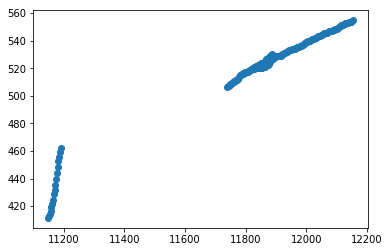

In [168]:

fig = plt.figure()

#I THINK I HAVE TO DO THIS IN A FOR LOOP
#for trib in tributaries....

# creek_movern_df.plot(x='m_over_n__01', y='elevation', style='bo')#with pandas
plt.scatter(TributariesX,TributariesElev)#,c=.999, s=500)#,cmap=this_cmap, norm=cNorm, marker='*')#, markersize=5,edgecolors='none')#, c=c, cmap=this_cmap, norm=cNorm, s=2.5, edgecolors='none')

plt.show()


#plt.scatter(x,y,z,s=5, cmap=colormap, norm=normalize, marker='*')

In [100]:
plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)

In [359]:
creek_movern_df.head()

,Tributary,basin_key,elevation,m_over_n__01,m_over_n__02,m_over_n__03,m_over_n__04,m_over_n__05,m_over_n__06,m_over_n__07,m_over_n__08
0,0.000,0.000,557.960,12269.000,1705.200,252.080,40.388,7.087,1.357,0.279,0.061
1,0.000,0.000,557.890,12266.000,1704.300,251.820,40.321,7.069,1.352,0.278,0.060
2,0.000,0.000,557.570,12263.000,1703.600,251.650,40.274,7.056,1.349,0.277,0.060
3,0.000,0.000,557.490,12261.000,1703.000,251.470,40.226,7.043,1.345,0.276,0.060
4,0.000,0.000,557.310,12257.000,1702.000,251.220,40.159,7.025,1.341,0.275,0.060
